# Checks

In [4]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Check if TensorFlow was built with GPU support
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU available:", tf.config.list_physical_devices('GPU'))

import sys
print()
print("Python version:", sys.version)

TensorFlow version: 2.4.1
Built with CUDA: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Python version: 3.7.5 (tags/v3.7.5:5c02a39a0b, Oct 15 2019, 00:11:34) [MSC v.1916 64 bit (AMD64)]


# Step 1 : Import Libraries

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

from tensorflow.keras import mixed_precision

# Enable mixed precision globally
mixed_precision.set_global_policy('mixed_float16')



INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


# STEP 2: Set Parameters

In [6]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 300  # You already balanced to 300 identities
TRAIN_DIR = 'vggface2_subset/train'
VAL_DIR = 'vggface2_subset/val'


#  STEP 3: Data Generators

In [7]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 36000 images belonging to 300 classes.
Found 9000 images belonging to 300 classes.


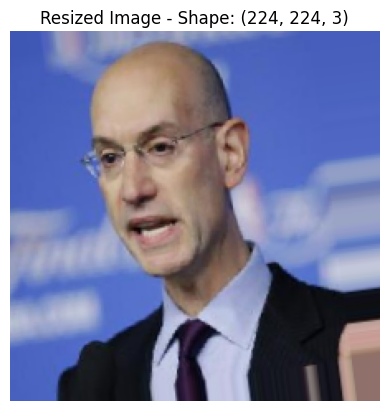

In [8]:
#CHECKING WHAT THE RESIZED IMAGE LOOKS LIKE

import matplotlib.pyplot as plt
import numpy as np

# Get a single batch
images, labels = next(train_data)

# Show the first image
plt.imshow(images[0])
plt.title(f"Resized Image - Shape: {images[0].shape}")
plt.axis('off')
plt.show()


# STEP 4: Build VGG19 Model (Warm-Up Phase)

In [9]:
# Load VGG19 without top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#  STEP 5: Warm-Up Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping: stops training when val_accuracy doesn't improve for 3 epochs
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# ModelCheckpoint: saves the best model to disk (based on val_accuracy)
checkpoint = ModelCheckpoint(
    "vgg19_warmup_best_model.h5",       # filename
    monitor='val_accuracy',
    save_best_only=True,                # only save when val_accuracy improves
    save_weights_only=False,            # saves architecture + weights
    mode='max',
    verbose=1
)

# Re-run warm-up training
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, checkpoint]  # <- both callbacks here
)


Epoch 1/20
1125/1125 [==============================] - 630s 553ms/step - loss: 5.7278 - accuracy: 0.0055 - val_loss: 5.5266 - val_accuracy: 0.0126

Epoch 00001: val_accuracy improved from -inf to 0.01256, saving model to vgg19_warmup_best_model.h5
Epoch 2/20
1125/1125 [==============================] - 406s 361ms/step - loss: 5.5179 - accuracy: 0.0100 - val_loss: 5.1920 - val_accuracy: 0.0267

Epoch 00002: val_accuracy improved from 0.01256 to 0.02667, saving model to vgg19_warmup_best_model.h5
Epoch 3/20
1125/1125 [==============================] - 363s 322ms/step - loss: 5.3190 - accuracy: 0.0130 - val_loss: 4.9605 - val_accuracy: 0.0423

Epoch 00003: val_accuracy improved from 0.02667 to 0.04233, saving model to vgg19_warmup_best_model.h5
Epoch 4/20
1125/1125 [==============================] - 412s 366ms/step - loss: 5.1613 - accuracy: 0.0198 - val_loss: 4.8069 - val_accuracy: 0.0578

Epoch 00004: val_accuracy improved from 0.04233 to 0.05778, saving model to vgg19_warmup_best_mode

#  STEP 6 – Fine-Tuning Code

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Load the model you saved during warm-up
model = load_model("vgg19_warmup_best_model.h5")


In [ ]:
# Unfreeze last 10 layers of the model
for layer in model.layers[-10:]:
    layer.trainable = True


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # 🔥 very important for fine-tuning!
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "vgg19_finetuned_best_model.h5",     # new model name
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-7
)

In [ ]:
history_stage1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,  # safe upper limit for stage 1
    callbacks=[early_stop, checkpoint, reduce_lr]
)


In [ ]:
#plotting Stage-1 Results
import matplotlib.pyplot as plt

# Accuracy Curve
plt.figure(figsize=(10, 4))
plt.plot(history_stage1.history['accuracy'], label='Train Accuracy')
plt.plot(history_stage1.history['val_accuracy'], label='Val Accuracy')
plt.title('Stage 1 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Curve
plt.figure(figsize=(10, 4))
plt.plot(history_stage1.history['loss'], label='Train Loss')
plt.plot(history_stage1.history['val_loss'], label='Val Loss')
plt.title('Stage 1 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save("vgg19_finetuned_stage1.h5")


## STEP 6.1 - Stage 2

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 1. Load the best model from Stage 1
model = load_model("vgg19_finetuned_best_model.h5")  # Or use 'vgg19_finetuned_stage1.h5' if you saved manually

# 2. Unfreeze the last 20 layers of the model
for layer in model.layers[-20:]:
    layer.trainable = True

# 3. Re-compile the model with a low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Redefine callbacks (use same ones)
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "vgg19_finetuned_best_model.h5",  # <- same file as Stage 1
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-7
)

# 5. Train Stage 2
history_stage2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,  # Again, EarlyStopping will stop early if needed
    callbacks=[early_stop, checkpoint, reduce_lr]
)


In [ ]:
model.save("vgg19_final_stage2.h5")

In [ ]:
#Plotting Train vs Val Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_stage2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_stage2.history['accuracy'], label='Training Accuracy')
plt.title('Stage 2: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Plotting Train vs Val Loss
plt.figure(figsize=(10, 10))
plt.plot(history_stage2.history['val_loss'], label='Validation Loss')
plt.plot(history_stage2.history['loss'], label='Training Loss')
plt.title('Stage 2: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#This was to save the history of stage 2 model
import pickle

# Save the history dictionary to a file
with open("history_stage2.pkl", "wb") as f:  #save as history_stage2.pkl in our working directory
    pickle.dump(history_stage2.history, f)


In [ ]:
#This is to load the history of stage 2 model
import pickle

# Load the saved history
with open("history_stage2.pkl", "rb") as f:
    history_dict = pickle.load(f)


class HistoryWrapper:
    def __init__(self, history_dict):
        self.history = history_dict

history_stage2 = HistoryWrapper(history_dict)
from tensorflow.keras.models import load_model

In [21]:
from tensorflow.keras.models import load_model

model = load_model("vgg19_finetuned_best_model.h5") 

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [20]:
!pip install pydot
!pip install graphviz



   ---------------------------------------- 47.0/47.0 kB 71.3 kB/s eta 0:00:00
